# Predicting Median House Value with Regression

**Author**: Devin Thai (devin.thai.5@gmail.com)

## Introduction
Today, we are going to be looking at the Boston Housing dataset, available [here](https://www.kaggle.com/c/boston-housing). Our goal is not to achieve a high score, but to explore the data and insight workflow. With that being said, today's learning method of choice will be **Linear Regression**. This is because Linear Regression is perfect for predicting quantitative values such as the **median value of homes** and is one of the more interpretable machine learning methods.

Now, let's take care of some quick housekeeping.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(format='%(message)s', level=logging.INFO, stream=sys.stdout)
from boston_housing import data
from boston_housing import model

We can now use pandas to import the dataset.

In [2]:
df = pd.read_csv("/Volumes/2 TB Storage/datascience/boston_housing/exploration/data/train.csv")

Let's take a look at the variables we will be dealing with.

In [3]:
df.head()

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


"medv" is the median value of owner-occupied homes in thousands of dollars. in a particular area. This is our "target" variable, the value that we want to predict using the other variables.

"ID" is simply an identification number. This will be removed from our set of variables as it does not provide any useful information about the houses in their respective areas.

"crim" is the per capita crime rate by town.

"zn" is the proportion of residential land zoned for lots over 25,000 sq. ft.

"indus" is proportion of non-retail business acres per town.

"chas" is a Charles River dummy variable. A dummy variable is a variable whose value represents whether or not something is happening. In this case, "chas"' value is 1 if the Charles River bounds the tract/area around the homes and 0 if not.

"nox" is the nitrogen dioxide concentration in parts per 10 million. This is likely an indicator of pollution in the area.

"rm" is the average number of rooms per home.

"age" is actually proportion of owner-occupied units built prior to 1940. It is **not** the average age of homes.

"dis" is a weighted mean of distances to five of Boston employment centers.

"rad" is an index of accessibility to radial highways. Because this is an index, its values most likely represent groupings instead of some numerical quantity. We will check for this soon and convert "rad" into a dummy variable if necessary.

"tax" is the full-value property-tax rate per $10,000.

"ptratio" is the student to teacher ratio by town.

"black" is calculated using the formula 1000(Bk - 0.63)^2, where Bk is the proportion of blacks by town. This is not a very ethical use of data, so we will be leaving this variable out of our predictor variables.

"lstat" is lower status of the population (percent). This is basically a measure of poverty.

In [4]:
df = df.drop(['black', 'ID'], axis = 1)

## More Housekeeping
Before we can start doing any analysis, we have to verify a few more things about our data.

First, we check for missing data.

In [5]:
df.isna().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
lstat      0
medv       0
dtype: int64

It is important to make sure that none of our data has missing entries. Our data manipulation package, pandas, handles missing data as if they were 0's. This leads to inaccurate/skewed predictions if left untreated. Normally we have come up with a way to "impute", or fill in, these missing values before moving on, however, none of our variables are missing any entries.

Next, we have to make sure our variables are in suitable types.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 13 columns):
crim       333 non-null float64
zn         333 non-null float64
indus      333 non-null float64
chas       333 non-null int64
nox        333 non-null float64
rm         333 non-null float64
age        333 non-null float64
dis        333 non-null float64
rad        333 non-null int64
tax        333 non-null int64
ptratio    333 non-null float64
lstat      333 non-null float64
medv       333 non-null float64
dtypes: float64(10), int64(3)
memory usage: 33.9 KB


In [7]:
df['chas'].unique()

array([0, 1])

Recall that "chas" is supposed to be a dummy variable. That means its values must be 0 or 1, which is true in this case, so we will not have to make any changes to "chas".

We previously pointed out that "rad" is an index and might need to be converted to a series of dummy variables. To check this, we will look at what unique values "rad" contains.

In [8]:
df['rad'].unique()

array([ 1,  2,  3,  5,  4,  8,  6,  7, 24])

Notice that "rad" does not have very many unique values. These values are indices that indicate accessibility to radial highways. Each area with the same "rad" value has the same level of accessibility, so each index should be treated as its own group. We can achieve this by creating a series of dummy variables to represent each index.

In [9]:
df['rad'] = df['rad'].astype('category')
rad_dummies = pd.get_dummies(df['rad'])
df = df.drop('rad',axis = 1)

In [10]:
rad_dummies.head()

,1,2,3,4,5,6,7,8,24
0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0


Let us elaborate more on the meaning of our dummy variables. Notice in the above table that the "0" entry has a value of 1 under 1 and 0 everywhere else. This means that "0" belongs in group 1 and not in any of the others. Similarly, "1" is a member of group 2 and not any of the others. Next, "2" is a member of group 3 and so on.

Next, we need to check the distributions of our variables. We do this by looking at histograms of our variables.

0

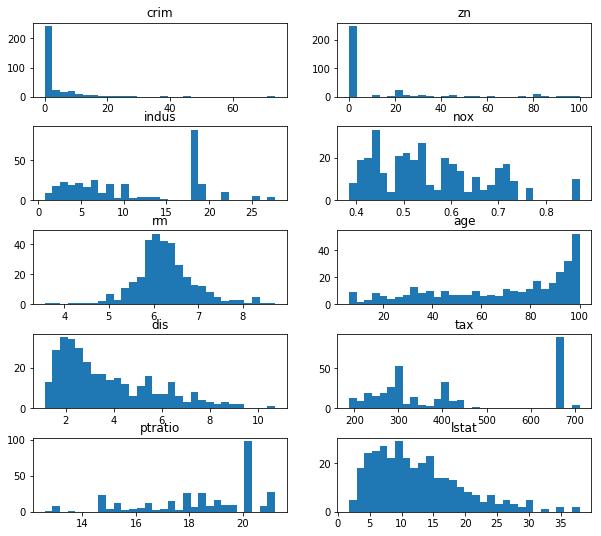

In [11]:
data.distmap(df)

We are looking at the horizontal axes of these histograms. Notice that the ranges of our data vary significantly. This is important because it is difficult to compare values of different variables with different ranges. For example, let's look at a value of 25 in the context of both the "zn" and "indus" variables. At a purely quantitative level, 25 is equal to 25. However it is not that simple. 25 is on the lower end of "zn"'s range whereas 25 is on the upper end of "indus"' range. We have to reconcile this information in our analysis. In order to do so, we are going to "scale" our variables by mapping each point into the "standard normal" distribution. That is done with the following formula:

$Z = \frac{X-\mu}{\sigma}$, where Z is the the value in the standard normal distribution, $\mu$ is the average value of a given variable, X is the particular value of the variable, and $\sigma$ is the standard deviation of the variable.

Each of the Z values represents information about the original value's distance from the mean/average value of the variable. When we compare Z values, we are comparing relative distances rather than magnitudes, making comparisons more meaningful. This should also bring each of the variables' respective ranges closer together. This makes it much easier to compare values across variables.

In [12]:
features = data.scaler(df)

0

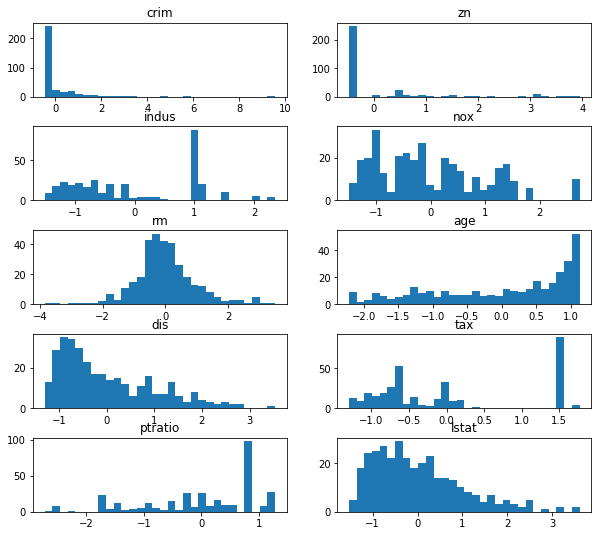

In [13]:
data.distmap(features)

As we can see, all of the ranges have become much closer in scale.

Now that we've taken care of all of this, we can add our dummy variables to our data and move on.

In [14]:
scaled_feats = features.drop('medv', axis = 1)
chas_medv = df.drop(scaled_feats.columns, axis = 1)

features = pd.concat([scaled_feats, chas_medv, rad_dummies], axis = 1)

## Checking for Multicolinearity

Now we need to look at the interactions between our variables. This is important because we want to include as little redundant information as possible. Removing redundant information simplifies our model and makes it more generalizable.

In [15]:
data.tol_vif_table(features, n = 11)

Correlation  Tolerance       VIF
tax   24       0.901940   0.186504  5.361811
nox   dis      0.769364   0.408079  2.450507
age   dis      0.764208   0.415987  2.403923
indus nox      0.750087   0.437369  2.286400
lstat medv     0.738600   0.454470  2.200365
nox   age      0.736000   0.458305  2.181955
indus tax      0.708313   0.498292  2.006854
      dis      0.702327   0.506737  1.973411
rm    medv     0.689598   0.524454  1.906743
crim  24       0.674004   0.545718  1.832448
nox   tax      0.670722   0.550131  1.817747

These are the top 11 pairs of variables along with their correlation, tolerance, and VIF (Variance Inflation Factor) values.

Correlation is a measure of what proportion of variance in one variable can be explained by the variance in the other variable. In other words, how much information in one variable can be adequately represented by another variable. This is what we mean when we talk about redundant information. If one variable can explain most of the information provided by another variable, it is reasonable to just get rid of the extraneous variable.

Tolerance is calculated using the formula:
Tolerance = $1-r^{2}$, where r is the correlation value. Tolerance < 0.1 tends to indicate problematic relationships.

VIF is calculated using the formula:
VIF = $\frac{1}{\text{Tolerance}}$. Similarly, VIF > 10 tends to be problematic

Using the guidelines specified, we do not have to worry about colinearity between our variables.

## Dimensionality Reduction

Dimensionality reduction is another way in which we can simplify our model. As previously mentioned, we can look at the interactions between our variables to see if there are any we can get rid of. Now we can compare model performance and model complexity to simplify our model. To do this, we are going to be using another form of regression called LASSO.

In [16]:
data.lasso_reduction(features)

,Used Features,Training Score,Test Score
1,3,0.630353,0.649038
0.1,15,0.708203,0.725419
0.01,19,0.736713,0.724902
0.001,19,0.737105,0.721835


Judging by the graph, 15 seems to be the optimal amount of features to use. This is because when we use 19 features, the training and test scores are pretty similar, but we have to use 4 additional features. More features means greater odds that the model will overfit and generalize less accurately. So, we will consider just using the features from the 0.1 LASSO regression.

In [17]:
lasso01_feats = data.get_lasso_coef(features, 0.1)

## Model Creation

Now that we are done treating our data and simplifying our model, we can finally create our linear regression model. Compared to the rest of this notebook, this is probably the simplest part.

In [18]:
lin_reg, ctable = model.run_linear_regression(features,lasso01_feats)

The prediction accuracy with the linear regression model is 72.2%


The expected prediction accuracy for the linear regression model we created is 72.2%. This is a moderately good prediction accuracy. However, we did not chose Linear Regression for its prediction accuracy, but rather for its interpretability. Now we are going to draw insight about our model by interpretting the coefficients of our model.

### Linear Regression Interpretation
What do I mean by coefficients? The Linear Regression method is defined as such:

$\hat{y} = \beta_{0}X_{0} + ... + \beta_{n}X_{n}$, where $\hat{y}$ is the predicted value, $X_{i}$ is the $i^{th}$ predictor variable, and $\beta_{i}$ is the coefficient for the $i^{th}$ variable.

If we can understand what each $\beta_{i}$ means, then we can extract some insights about how each predictor variable affects the prediction. The following table shows each variable along with its coefficient.

In [19]:
ctable

,Coefficients
crim,-1.097766
zn,1.033705
nox,-1.838442
rm,2.538782
age,-0.490224
dis,-2.970808
ptratio,-1.502282
lstat,-4.209550
chas,4.156605
1,-3.837608


We have to be aware of the fact that we scaled our predictors because this changes the way that we interpret our coefficients. Normally we would say that an increase of 1 unit of $X_{i}$ is associated with a $\beta_{i}$ change in $\hat{y}$. But because we have remapped each $X_{i}$ to $Z_{i}$, in the standard normal distribution, we now have:

$Z_{i} = \frac{X{i}-\mu_{i}}{\sigma_{i}}$, where each $X_{i}$ is the original $i^{th}$ variable, $\mu_{i}$ is the mean/average of the $i^{th}$ variable, and $\sigma_{i}$ is the standard deviation of the $i^{th}$ variable.

Then we will interpret each coefficient as follows: For each $\sigma_{i}$ increase in $X_{i}$, there is as associated $\beta_{i}$ change in $\hat{y}$. In other words, for each standard deviation change of an associated variable, there is a $\beta_{i}$ change in $\hat{y}$.

In [20]:
model.coef_std_table(ctable, df, lasso01_feats, rad_dummies)

,Coefficients,Standard Deviations
crim,-1.097766,7.352272
zn,1.033705,22.674762
nox,-1.838442,0.114955
rm,2.538782,0.703952
age,-0.490224,28.133344
dis,-2.970808,1.981123
ptratio,-1.502282,2.151821
lstat,-4.209550,7.067781
chas,4.156605,0.237956
1,-3.837608,0.200987


Let us use "crim" as an example. For every 7.352272 increase in the per capita crime rate of a town, there is an associated average/expected decrease of $1097.77 in the median value of homes in that town. This sort of interpretation works on all of the quantitative predictors, however interpretation is different for dummy variables.

Our dummy variables in this case are: "chas", "1", "3", "4", "6", "8", and "24". Recall that a dummy variable represents whether or not something is true. Then, the standard deviation of a given dummy variable is not a very useful number when interpreting coefficients. We will use "chas" as an example. If a given tract is bound by the Charles river, then there is an associated average/expected increase of $4,156.61 in the median value of homes in that area.

Once we interpret our coefficients in this manner, we will be able to make inferences on what influence each predictor has on the median value of homes.

## Future Improvements

Although we were able to create a Linear Regression model and interpret it to obtain some insights, there is still room for improvement in this analysis. For instance, while we did handle having mismatched scales, we would also have benefited greatly from transforming our variables further to ensure that our predictors are **normally distributed**. On top of that, we should have been more rigorous in making sure the assumptions of Linear Regression were met. In this case, we should have checked the normality of residuals and correlation between residuals and the target variable.